In [1]:
#loading packages

import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import glob
use_cuda = torch.cuda.is_available()

In [ ]:
#getting 2000 samples randomly from validation set and their corresponding bounding boxes, 
# Sorry for absolute pathes:))
'''
import xml.etree.ElementTree as ET
import os
import glob
from random import sample
aaa = 0
bbb = 0
####################################################################################################

# In this chunk of code I simply remove xml files that have more than 1 bounding boxes!
# This '/home/mallet/Downloads/val/*.xml' path is 
# referring to bounding boxes for all 50k images of validation set in image net. 
# 11715 images out of this 50k has more than 1 bounding boxes.

val_files = glob.glob('/home/mallet/Downloads/val/*.xml')
filcounter = 0
for file in val_files:
    root = ET.parse(file).getroot()
    bnbxcntr = 0
    for bnd in root.findall('./object/bndbox'):
        bnbxcntr+=1
    if bnbxcntr>1:
        os.remove(file)
        filcounter+=1
print(filcounter)

####################################################################################################

# In this chunck, I am removing those 11715 images from imageset as well,
# since I removed their BB in last section. This '/home/mallet/Desktop/VanillaVsARobust/valid/' refers
# to all 50k images of validation set that I want to remove 11715 of them. 
# And this '/home/mallet/Downloads/val/*.xml' is simply those xml files that I obtained in previous section
# after removing those 11715!

flss = os.listdir('/home/mallet/Desktop/VanillaVsARobust/valid/')
bbfiles = glob.glob('/home/mallet/Downloads/val/*.xml')
print(type(bbfiles))
for fls in flss:
    files = os.listdir('/home/mallet/Desktop/VanillaVsARobust/valid/'+fls)
    for file in files:
        d = '/home/mallet/Downloads/val/' + file.split(".")[0] + '.xml'
        if d in bbfiles:
            aaa+=1
        else:
            os.remove('/home/mallet/Desktop/VanillaVsARobust/valid/'+fls+'/'+file)
            bbb+=1
print(aaa, bbb)
####################################################################################################

# After previous 2 steps, now I have 2 set of 38285 in both Jpeg and xml. now I randomly keep 2 images from
# each category/class which will result in having 2000 images and removing 36285 images.

asa = 0
flss = os.listdir('/home/mallet/Desktop/VanillaVsARobust/valid/')
bbfiles = glob.glob('/home/mallet/Downloads/val/*.xml')
for fls in flss:
    files = os.listdir('/home/mallet/Desktop/VanillaVsARobust/valid/'+fls)
    for file in sample(files,len(files)-2):
        #d = '/home/mallet/Downloads/val/' + file.split(".")[0] + '.xml'
        os.remove('/home/mallet/Desktop/VanillaVsARobust/valid/'+fls+'/'+file)
        os.remove('/home/mallet/Desktop/VanillaVsARobust/bb/'+file.split(".")[0] + '.xml')
        asa+=1   
print(asa)
'''

36285


In [74]:
#preparing data set

def normalize_transform():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    
val_transforms = transforms.Compose([transforms.ToTensor(),normalize_transform()])    
val_dataset = datasets.ImageFolder('/home/mallet/Desktop/VanillaVsARobust/validationSample/',transform = val_transforms)

In [84]:
val_class = []
 
with open('/home/mallet/Desktop/VanillaVsARobust/ILSVRC2012_validation_ground_truth.txt') as val_file:
    rows = val_file.readlines()
    for row in rows:
        row = int(row.strip())
        val_class.append(row)

In [85]:
val_files = glob.glob('val/*.JPEG')
for file in val_files:
    seq_num = int(file.split("_")[-1].split(".")[0])
    class_id = val_class[seq_num - 1]
    cid = class_id - 1
    id = f"{cid:03}"
    if not os.path.isdir('validationSample/' + id):
        os.mkdir('validationSample/' + id)
 
    os.rename(file, 'validationSample/' + id + "/"+file.split("/")[-1])

In [92]:
a = torch.randn(4, 6)
print(a)
b = torch.argmax(a)
x, y = a.shape
xloc = b//y
yloc = b%6

tensor([[-0.8662,  0.3392,  0.0285, -0.4382,  2.9259,  0.6567],
        [ 0.7548,  1.2167,  0.8650,  0.4994,  0.7251, -0.5246],
        [-1.1198, -0.9046,  0.1769,  0.7497, -0.7918, -0.3651],
        [-1.1663, -0.4158,  3.6088,  0.5614, -1.8190,  1.1314]])


tensor(20)

In [103]:
a = np.array([[0.54,0.2,.33],[0.34,0.43,0.98]])
i,j = np.unravel_index(a.argmax(), a.shape)
a[i,j]
print(i, j)

1 2


In [27]:
import torchray
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import time
import torch
from torch.autograd import Variable
from torchvision import models
import sys
from numpy import savetxt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import glob
import torchray.benchmark
from torchray.attribution.gradient import gradient
from matplotlib import pyplot as plt
import torchray.benchmark.pointing_game
import miscel
import loadmodel as lm

use_cuda = torch.cuda.is_available()

val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])    

vall = torchray.benchmark.datasets.ImageFolder('/home/mallet/Desktop/VanillaVsARobust/validationSample',transform = val_transforms)

ttotal = 0
pgtot = 0
l = []
model = lm.loadResnetR()
for i in range(2000):
    img, labele = vall[i]
    bbname = vall.get_image_url(i).split("/")[-1].split(".")[0]
    imwidth, imheight, xmin, ymin, xmax, ymax = miscel.bbinfo(bbname)
    x = img.unsqueeze(0)
    x = x.cuda()
    start = time.time()
    saliency = gradient(model, x, labele)
    end = time.time()
    tm = end - start
    l.append(tm)
    xloc,yloc = miscel.findloc(saliency, imwidth, imheight)
    Y = miscel.gtbb(imwidth, imheight, xmin, ymin, xmax, ymax)
    test = torchray.benchmark.pointing_game.PointingGame(1000, tolerance=15)
    pg = test.evaluate(Y, (yloc,xloc))
    if pg==1:
        pgtot+=1
l = np.asarray(l)     
print(pgtot/2000)

My Attacker is True
Loading the robust ResNet-50 architectre
=> loading checkpoint './models/ResNet50_R.pt'
=> loaded checkpoint './models/ResNet50_R.pt' (epoch 105)
0.732


In [34]:
from numpy import savetxt

savetxt('/home/mallet/Desktop/VanillaVsARobust/Runtimes/timeGradResnetR.csv', l, delimiter=',')

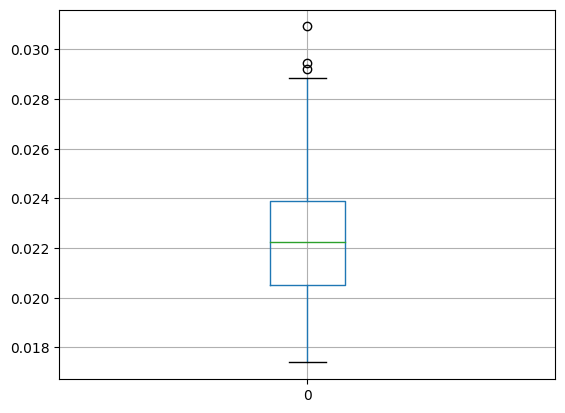

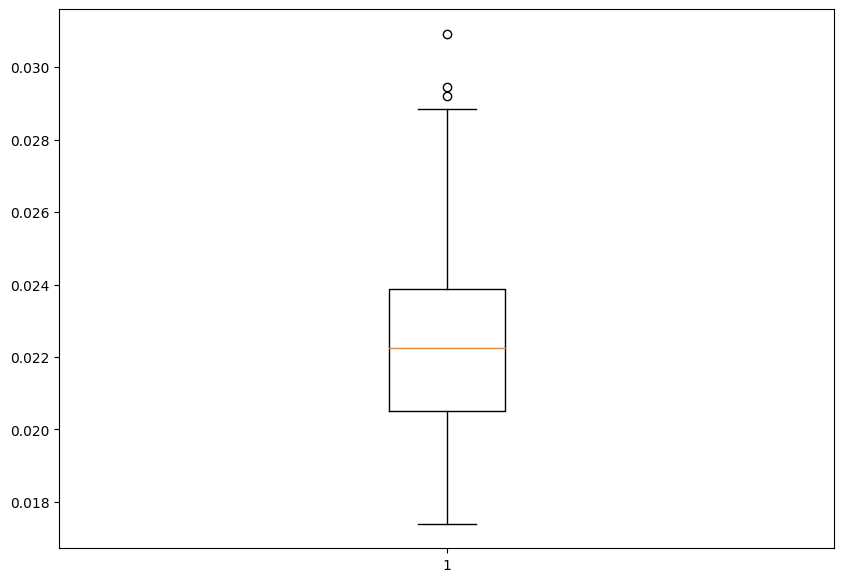

In [32]:
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(l)
 
# show plot
plt.show()

In [1]:
import sys
import os
sys.path.append('/home/mallet/Desktop/sam')
os.chdir('/home/mallet/Desktop/sam')

In [2]:
from sam.utils import load_madry_model
model = load_madry_model()


My Attacker is False
Loading the robust ResNet-50 architectre
=> loading checkpoint './models/ResNet50_R.pt'
=> loaded checkpoint './models/ResNet50_R.pt' (epoch 105)


In [11]:
import torchray.benchmark
import torchvision.transforms as transforms

val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])    
vall = torchray.benchmark.datasets.ImageFolder('/home/mallet/Desktop/VanillaVsARobust/validationSample',transform = val_transforms)
d = vall.selection
print(d)

for i in d:
    if i==0:
        print(i)
    elif i==1000:
        print(i)
    elif i==1999:
        print(i)
    elif i==2000:
        print(i)

range(0, 2000)
0
1000
1999


In [15]:
import xml.etree.ElementTree as ET
bbname = vall.get_image_url(0).split("/")[-1].split(".")[0]

tree = ET.parse('/home/mallet/Desktop/VanillaVsARobust/bb/'+ bbname + '.xml')
root = tree.getroot()
print(root[3][0])

<Element 'width' at 0x7f46f7cf4bf0>


In [19]:
import misc
imwidth, imheight, xmin, ymin, xmax, ymax = misc.bbinfo(bbname)
print(imwidth, imheight, xmin, ymin, xmax, ymax)
print(bbname)

500 375 47 187 481 362
ILSVRC2012_val_00009396
